## Homework 4: Parallelism

Due Tuesday Feb 22, 2022 @ 5pm

For this homework you will run the same algorithm under different parallelization methods and evaluate the speedups (execution time). You will compare simple serial (no parallelization), `multiprocessing` (or `concurrent.futures`), and `dask` (or `ray`, if you like).

The algorithm uses a Monte Carlo dart-throwing simulation to calculate a numerical approximation to $\pi$. A simple Python version of this program is below show how it can be implemented without parallelization. It is deliberately not copy-pastable so that you have to read it and (hopefully) understand it.

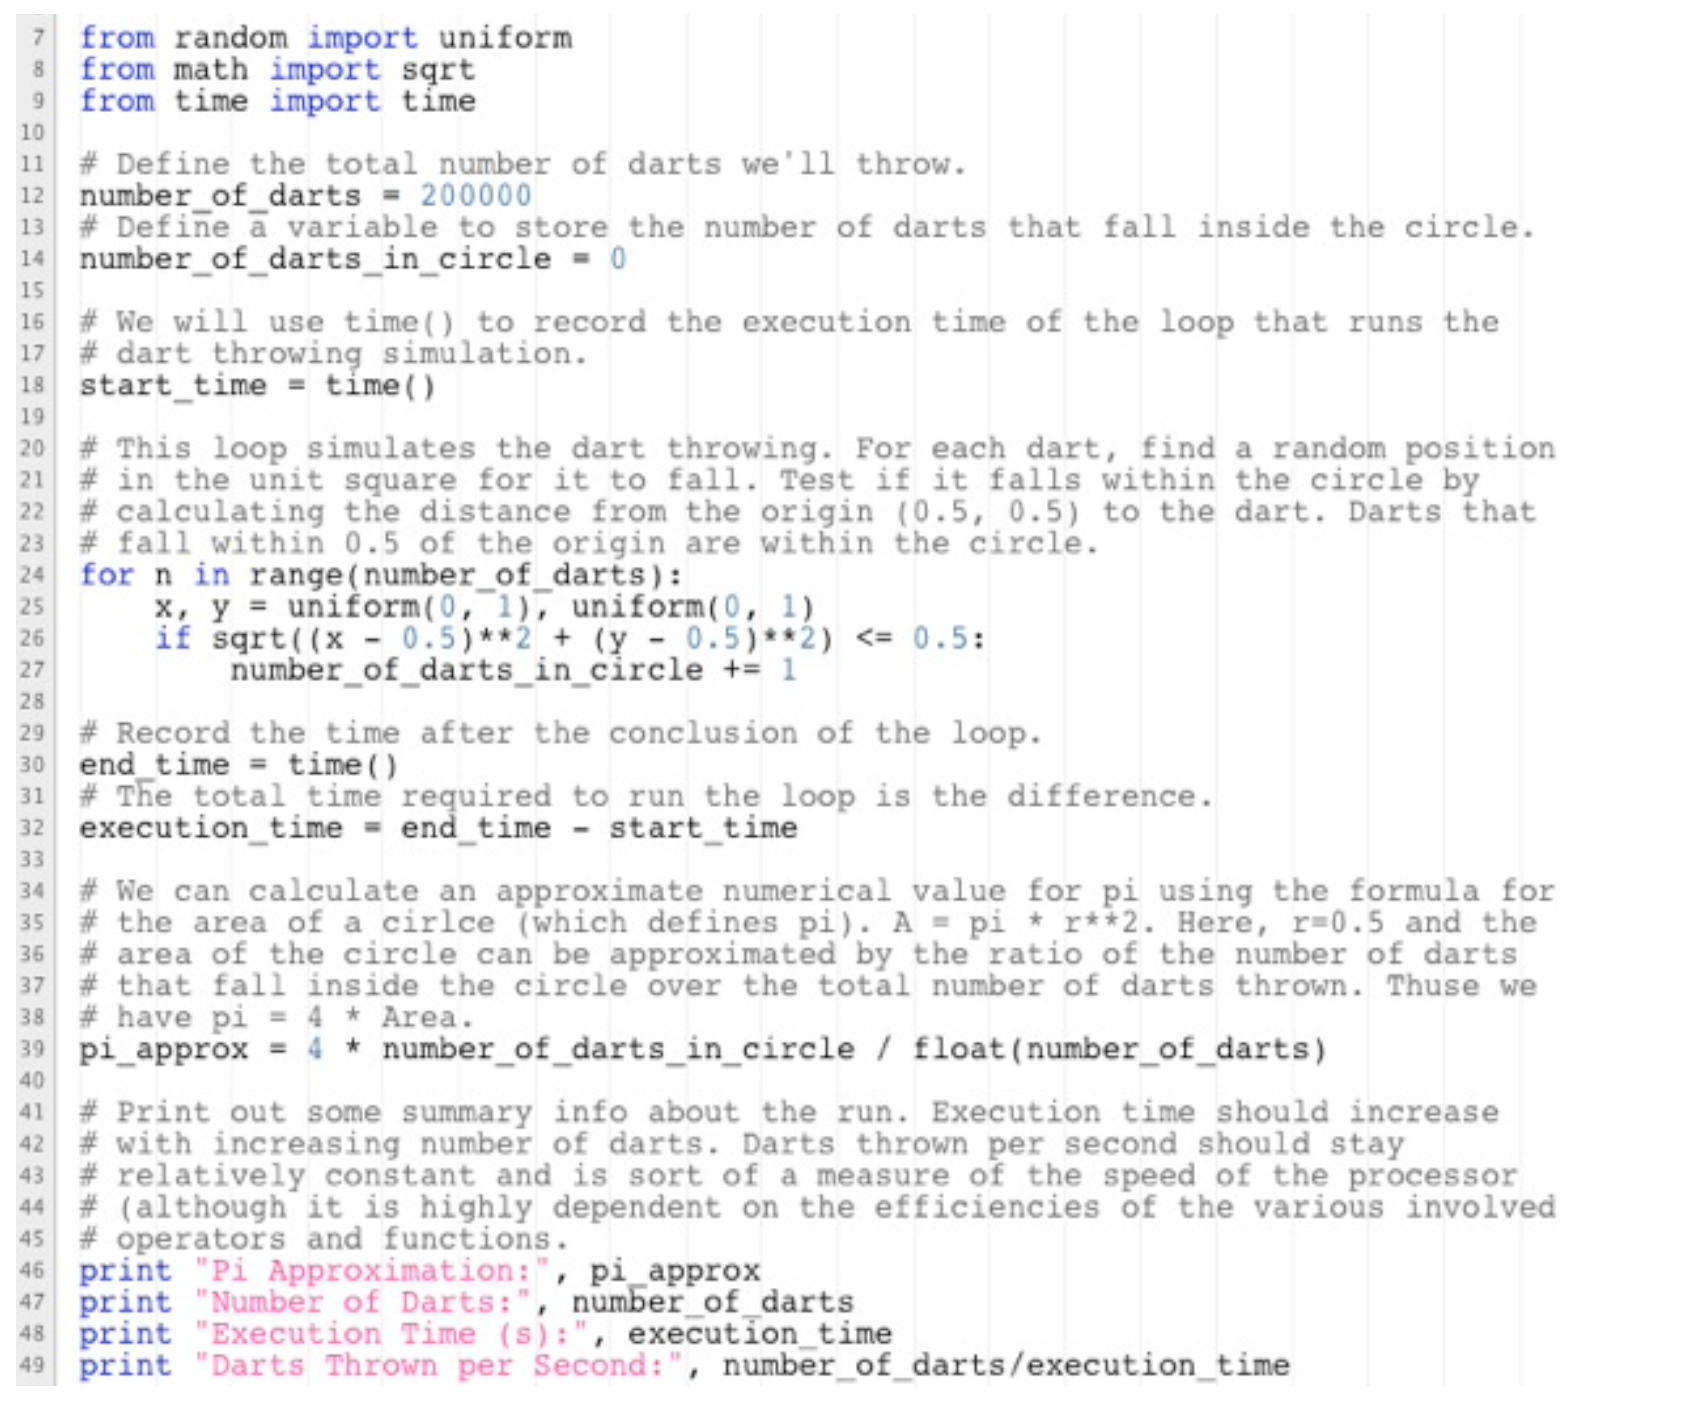

1. Write a program that runs this algorithm under the three different parallelization methods. Run several trials with different numbers of darts thrown (up to execution times ~100 seconds). Keep track of the execution times as a function of number of darts and method of parallelization. Also, keep track of the simulation rate (`darts thrown per second`). If you want to be awesome (!), you can run each simulation multiple times for each number of darts and calculate the standard deviation for the execution time and the simulation rate, but this is not required.

Execute a single dart throw. 

In [1]:
%%writefile throw_stuff.py
from random import uniform


def hit_target(n_darts): 
    """Throw a dart at a square; check if (x, y) coords 
    hit inscribed circle 
    
    Parameters
    ----------
    None
        
    Returns
    -------
    in_circle : bool
        True if dart hit circle
        
    """
    
    # define square inscribed circle
    len_square = 1
    rad_circle = len_square / 2
    
    # throw a uniform dart!
    x = uniform(0, len_square)
    y = uniform(0, len_square)
    
    # check if hit circle
    in_circle = (x - rad_circle)**2 + (y - rad_circle)**2 <= rad_circle**2
    
    return int(in_circle)


def throw_darts_serial(n_darts):
    """Throw darts at a square. Execute serially! Count 
    how many end up in an inscribed circle. Approximate pi. 

    Parameters
    ----------
    n_darts : int
        Number of darts to throw

    Returns
    -------
    pi_approx : float
        Approximation of pi
        
    """
    
    n_success = 0
    
    for dart in range(n_darts):
        if hit_target(dart):
            n_success += 1

    pi_approx = 4 * n_success / n_darts
    
    return pi_approx

Writing throw_stuff.py


Make parallelizations to throw darts.

In [2]:
# concurrent, using processes 
from concurrent.futures import ProcessPoolExecutor
from throw_stuff import throw_darts_serial
import numpy as np
def throw_darts_concurrent(n_darts):
    """Throw darts at a square. Split into batches that are 
    executed with concurrent.futures! (Each batch is still serial). 
    Count how many end up in an inscribed circle. Approximate pi. 

    Parameters
    ----------
    n_darts : int
        Number of darts to throw

    Returns
    -------
    pi_approx : float
        Approximation of pi
        
    """
    
    n_processes = 2; #I have a 2-core machine; speed doesn't improve >2
    
    # split up darts evenly among processes
    n_darts_each = np.repeat(int(np.floor(n_darts / n_processes)), n_processes)
    n_darts_each[0] += n_darts - n_darts_each.sum()    
    
    # run batches
    executor = ProcessPoolExecutor(n_processes)
    futures = [executor.submit(throw_darts_serial, n) for n in n_darts_each]
    outcomes = [f.result() for f in futures]

    # average results
    pi_approx = np.array(outcomes).mean()
    return pi_approx


In [ ]:
# dask!

Time outcomes from different algorithms. Increment number of darts in powers of 10; do multiple repetitions of each power.

In [5]:
# time multiple iterations

from time import time
import numpy as np

def bake_pies(n_powers, n_reps, throw_darts=throw_darts_serial):
    """Repeat dart throws with different strategies (default = 
    serial); increment dart numbers up to 10**n_powers, with 
    n_reps at each level.
    
    Parameters
    ----------
    n_powers : int
        Max number of darts; increment in powers of 10
    n_reps : int
        Number of repetitions for each power level
    throw_darts : function
        Function to use to execute dart throws; use serial by default

    Returns
    -------
    pi_est : numpy array
        Pi approxiations; n_reps x n_powers
    t_est : numpy array
        Execution time; n_reps x n_powers
        
    """
    
    # init output arrays
    pi_est = np.empty((n_reps, n_powers))
    t_est = np.empty((n_reps, n_powers))
    
    # repeat dart throws for each power
    for e in np.arange(n_powers):
        n_darts = 10**(e+1)
        for r in range(n_reps):
            t0 = time()
            pi_est[r, e] = throw_darts(n_darts) 
            t_est[r, e] = time() - t0
    
    return pi_est, t_est

In [6]:
# visualize results!

import matplotlib.pyplot as plt

def add_estimate(ax, y, strategy):
    # show distribution for estimates at each power
    m = y.mean(axis=0)
    sd = y.std(axis=0)
    
    n_powers = y.shape[1]
    
    p = ax.plot(np.arange(1, n_powers + 1), m, label=strategy)
#     ax.fill_between(np.arange(1, n_powers + 1), m - sd, m + sd, 
#                     color = p[0].get_color(), alpha=0.2)

In [11]:
n_powers = 8
n_reps = 1

In [12]:
%%time
[pi_serial, t_serial] = bake_pies(n_powers, n_reps, throw_darts_serial)

CPU times: user 2min 30s, sys: 1.46 s, total: 2min 31s
Wall time: 2min 40s


In [13]:
%%time
[pi_concurrent, t_concurrent] = bake_pies(n_powers, n_reps, throw_darts_concurrent)

CPU times: user 81.9 ms, sys: 149 ms, total: 231 ms
Wall time: 1min 47s


In [ ]:
# # approximate pi

# fig = plt.figure()
# ax = fig.add_subplot()
# add_estimate(ax, pi_serial, "serial")
# add_estimate(ax, pi_concurrent, "concurrent")

# ax.legend(frameon=False)

# plt.setp(ax, xticks=np.arange(1, n_powers+1), 
#          xlabel="number of darts (log10)",
#          ylabel="estimate of pi")

 Text(0.5, 0, 'number of darts (log10)'),
 Text(0, 0.5, 'time to simulate darts (s)'),
 None]

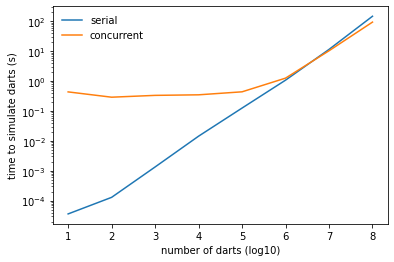

In [16]:
# time executions

fig = plt.figure()
ax = fig.add_subplot()

add_estimate(ax, t_serial, "serial")
add_estimate(ax, t_concurrent, "concurrent")

ax.legend(frameon=False)

plt.setp(ax, xticks=np.arange(1, n_powers+1),
         xlabel="number of darts (log10)",
         ylabel="time to simulate darts (s)",
         yscale="log")

 Text(0.5, 0, 'number of darts (log10)'),
 Text(0, 0.5, 'dart rate (throws/s)'),
 None]

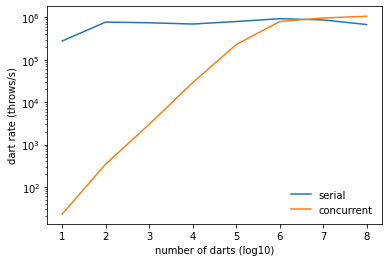

In [62]:
# simulation time

fig = plt.figure()
ax = fig.add_subplot()

n_darts = np.tile(10 ** np.arange(1, n_powers+1), (n_reps, 1))

add_estimate(ax, n_darts / t_serial.reshape(n_powers), "serial")
add_estimate(ax, n_darts / t_concurrent.reshape(n_powers), "concurrent")

ax.legend(frameon=False)
plt.setp(ax, xticks=np.arange(1, n_powers+1),
         xlabel="number of darts (log10)",
         ylabel="dart rate (throws/s)",
         yscale="log")

2. Plot execution time and simulation rate as a function of number of darts for all three methods. If you calculated standard deviations, use errorbar plots. See the example plot on the following page and try to emulate it. In your `README` file, explain the behavior you measure and illustrate in the plot. The grader should be able to simply run your submitted program and reproduce the plot.

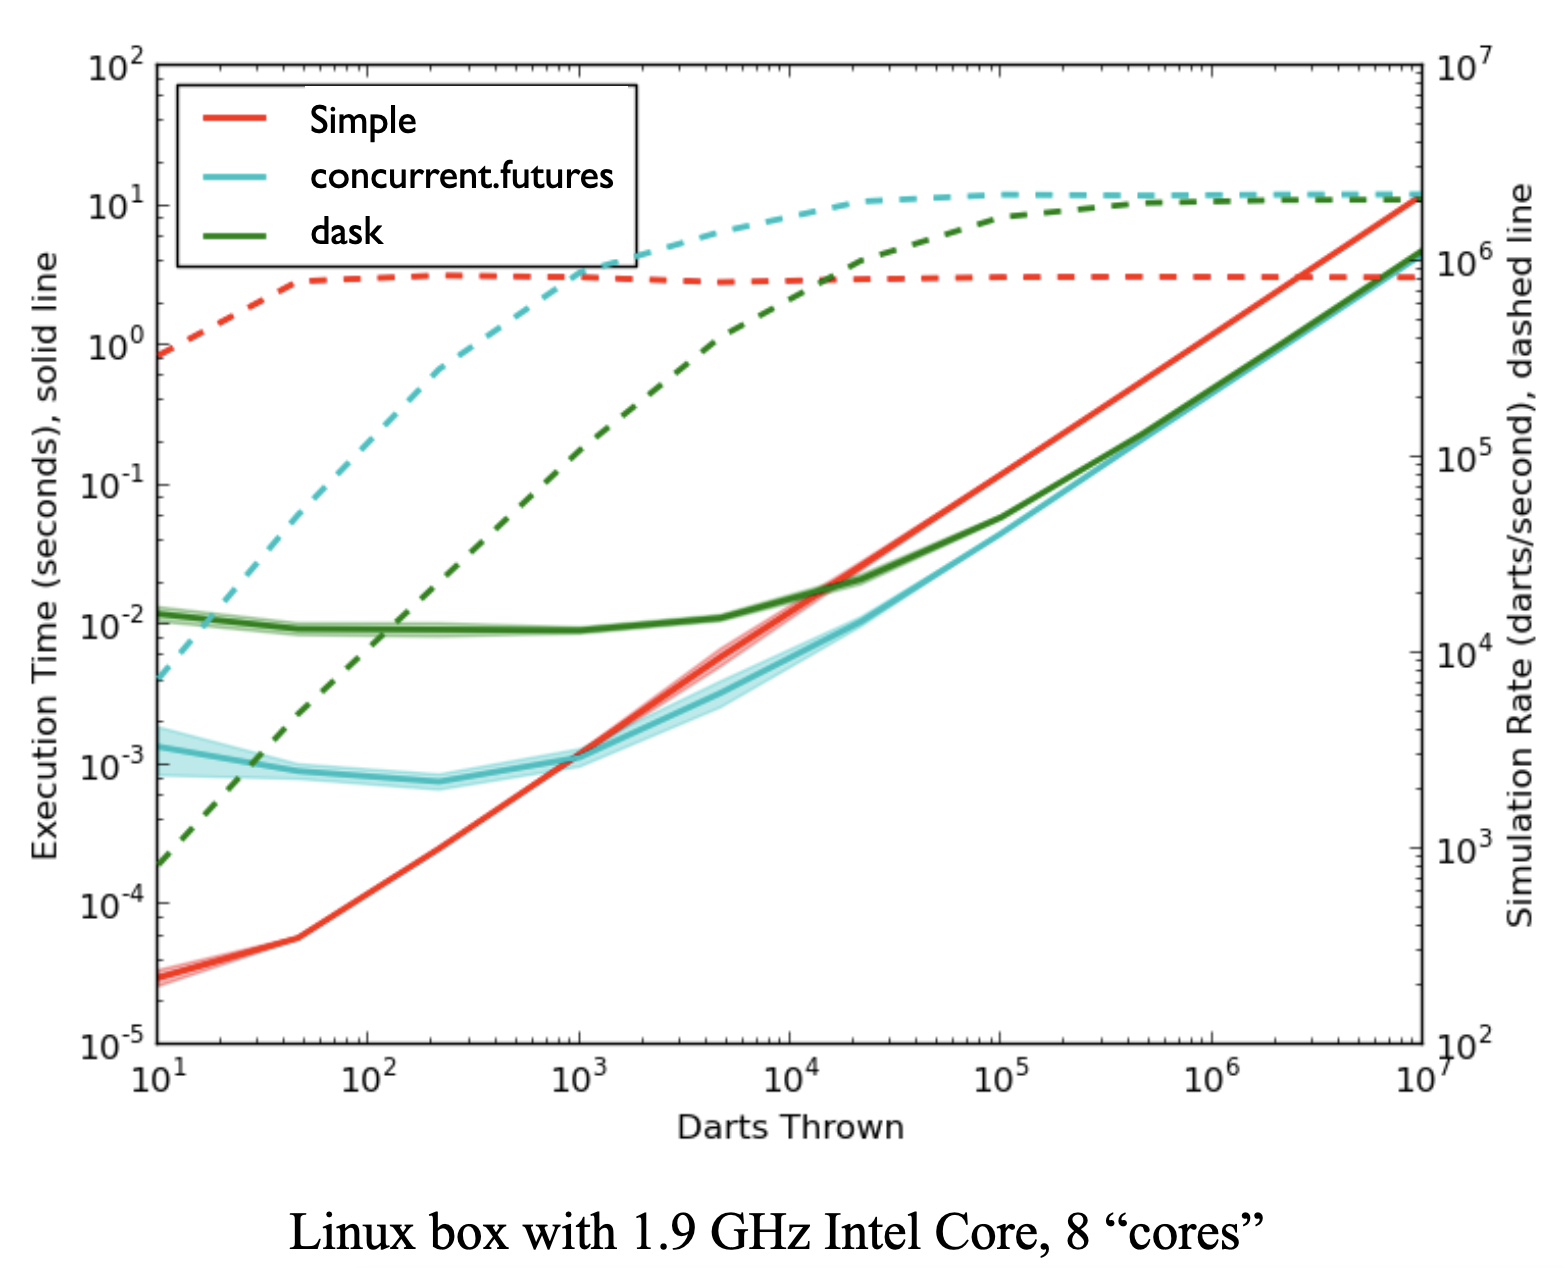

3. Write a short narrative explaining the differences and advantages between the approaches.